# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [10]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-io matplotlib==3.7.*

## 1.2 Load Dependencies

In [120]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from audio_utils import read_file_properties as auprops
import pandas as pd
from sklearn.preprocessing import OneHotEncoder 
import librosa
import numpy as np

# 2. Process the Dataset

## 2.1 Define Paths to Files

In [112]:
DATA_DIR = 'data'
METADATA = os.path.join(DATA_DIR, "metadata.csv")
MODEL_PATH = os.path.join(DATA_DIR, "model", "model.keras")
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav'),

In [14]:
LENGTH = 3 # seconds
N_MELS = 128
NUM_CHANNELS = 1

## 2.2 Label Encoding

In [15]:
label_encoder = OneHotEncoder()

classes = os.listdir(DATA_DIR)
classes.sort()
classes = np.array(classes).reshape(-1, 1)

label_encoder.fit(classes)
#labels = label_encoder.transform(classes).toarray()
#original_data = label_encoder.inverse_transform(labels)

def idx2label(idx):
    idx_reshaped = idx.reshape(1, -1)
    return label_encoder.inverse_transform(idx_reshaped)[0][0]

def label2idx(label):
    label = np.array(label).reshape(-1, 1)
    return label_encoder.transform(label).toarray()[0]

In [16]:
idx2label(label2idx('Parsed_Capuchinbird_Clips'))

'Parsed_Capuchinbird_Clips'

## 2.3 Exploratory data analysis

### Produce metadata dataframe

In [17]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATA_DIR):
    for i, file in enumerate(files):
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = auprops(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processed {i} file. {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Skipped 0 file. metadata.csv
Skipped 0 file. recording_00.mp3
Skipped 1 file. recording_01.mp3
Skipped 2 file. recording_02.mp3
Skipped 3 file. recording_03.mp3
Skipped 4 file. recording_04.mp3
Skipped 5 file. recording_05.mp3
Skipped 6 file. recording_06.mp3
Skipped 7 file. recording_07.mp3
Skipped 8 file. recording_08.mp3
Skipped 9 file. recording_09.mp3
Skipped 10 file. recording_10.mp3
Skipped 11 file. recording_11.mp3
Skipped 12 file. recording_12.mp3
Skipped 13 file. recording_13.mp3
Skipped 14 file. recording_14.mp3
Skipped 15 file. recording_15.mp3
Skipped 16 file. recording_16.mp3
Skipped 17 file. recording_17.mp3
Skipped 18 file. recording_18.mp3
Skipped 19 file. recording_19.mp3
Skipped 20 file. recording_20.mp3
Skipped 21 file. recording_21.mp3
Skipped 22 file. recording_22.mp3
Skipped 23 file. recording_23.mp3
Skipped 24 file. recording_24.mp3
Skipped 25 file. recording_25.mp3
Skipped 26 file. recording_26.mp3
Skipped 27 file. recording_27.mp3
Skipped 28 file. recording_28

### Observe the data

In [18]:
metadata.head()

,filename,label,class,num_channels,sample_rate,bit_depth,avg_rms,length_in_seconds,length_in_frames
0,data\Parsed_Capuchinbird_Clips\XC114131-0.wav,Parsed_Capuchinbird_Clips,"[0.0, 1.0, 0.0, 0.0]",2,48000,16,0.008838,2.5,120000
1,data\Parsed_Capuchinbird_Clips\XC114131-1.wav,Parsed_Capuchinbird_Clips,"[0.0, 1.0, 0.0, 0.0]",2,48000,16,0.007954,3.0,144000
2,data\Parsed_Capuchinbird_Clips\XC114131-2.wav,Parsed_Capuchinbird_Clips,"[0.0, 1.0, 0.0, 0.0]",2,48000,16,0.007164,3.5,168000
3,data\Parsed_Capuchinbird_Clips\XC114131-3.wav,Parsed_Capuchinbird_Clips,"[0.0, 1.0, 0.0, 0.0]",2,48000,16,0.007278,3.0,144000
4,data\Parsed_Capuchinbird_Clips\XC114131-4.wav,Parsed_Capuchinbird_Clips,"[0.0, 1.0, 0.0, 0.0]",2,48000,16,0.006439,3.5,168000


### class balance

In [19]:
print(metadata["label"].value_counts())

label
Parsed_Not_Capuchinbird_Clips    593
Parsed_Capuchinbird_Clips        217
Name: count, dtype: int64


### plot class waveforms

data\Parsed_Capuchinbird_Clips\XC114131-0.wav
data\Parsed_Not_Capuchinbird_Clips\afternoon-birds-song-in-forest-0.wav


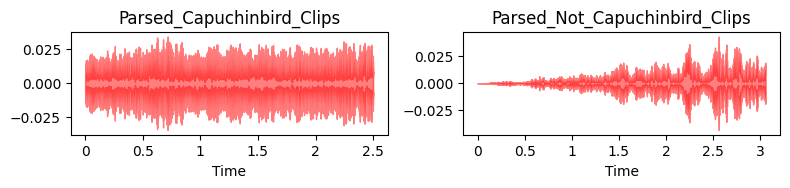

In [20]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name))
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show()  # This will display the plot

In [21]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
# print(audiodf.avg_rms.describe())

Channels: 
num_channels
2    0.858025
1    0.141975
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    0.867901
48000    0.118519
11025    0.013580
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count       810.000000
mean     139634.708642
std       19752.190954
min       22050.000000
25%      133138.000000
50%      134460.000000
75%      143545.000000
max      220500.000000
Name: length_in_frames, dtype: float64


Length (s): 
count    810.000000
mean       3.162455
std        0.314040
min        2.000000
25%        3.010998
50%        3.048005
75%        3.180998
max        5.000000
Name: length_in_seconds, dtype: float64


## 2.4 Audio Preprocessing:

### Test audio preprocessing
-   Librosa -> 
        SR: 22050
        channel: 1
    trim/pad ->
        length: 3s (3x22050)
    spectrogram ->
        mel-spectrogram / spectrogram / MFCC
    post-process ->
        to Db (log scale, more apparent patterns)
        abs 
    normalize ->
        
        


d:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


audio_file shape (66150,)
Spectrogram shape (128, 130)
spectrogram min: 0.0 spectrogram max: 80.0, average: 49.173763275146484
spectrogram dtype: float32
audio dtype: float32


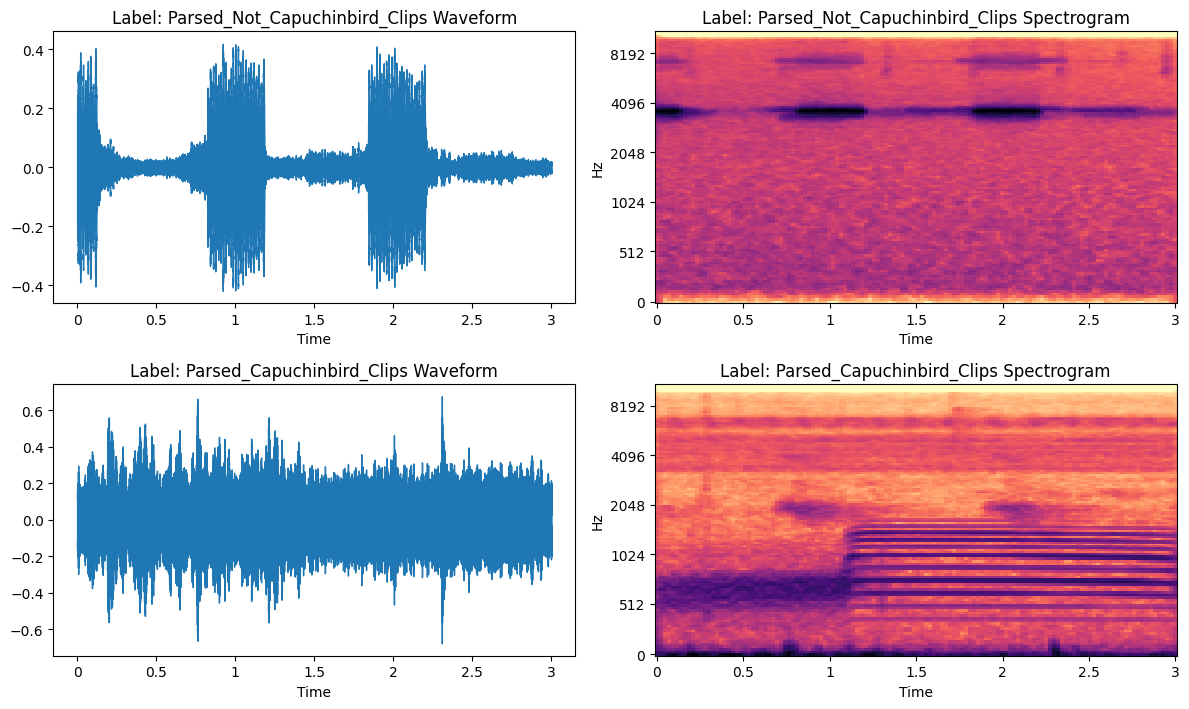

In [22]:
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
#rows = metadata.iloc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
rows = metadata.sample(2)
slice_length = 3
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 3.6))

for i, row in rows.iterrows():    
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"])
    if slice_length: 
        sample_length = slice_length * librosa_sample_rate

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)

    spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=librosa_sample_rate, n_mels=128, fmax = 12000, n_fft=2048, hop_length=512)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))
    spectrogram = np.abs(spectrogram)

        # wave Plot
    axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
    librosa.display.waveshow(audio_file, sr=librosa_sample_rate, ax=axes[pass_, 0])
    # spectrogram plot
    axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
    img = librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time', y_axis='mel', ax=axes[pass_, 1])
    pass_ += 1

#scaler = MinMaxScaler()
#scaler.fit(spectrogram)
#standardized_spectrogram = scaler.transform(spectrogram)


print(f"audio_file shape {audio_file.shape}")
print(f"Spectrogram shape {spectrogram.shape}")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
#print(f"spectrogram MinMax min: {standardized_spectrogram.min()} spectrogram max: {standardized_spectrogram.max()}, average: {standardized_spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype}")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

### Preprocessing functions

In [23]:
# Slice for common length of 3 seconds
def slice_audio(librosa_audio, librosa_sample_rate = 22050, slice_length = None):
    if slice_length == None:
        return librosa_audio
    SAMPLE_LENGTH = slice_length * librosa_sample_rate

    librosa_audio_sliced = librosa_audio[:SAMPLE_LENGTH]
    if len(librosa_audio) < SAMPLE_LENGTH:
        librosa_audio_sliced = np.pad(librosa_audio, (0, SAMPLE_LENGTH - len(librosa_audio)), constant_values=0)
    return librosa_audio_sliced

In [26]:
def extract_features(row, length, N_MELS):
    
    class_label = row["class"]
    
    audio_file, librosa_sample_rate = librosa.load(row["filename"])
    audio_file = slice_audio(audio_file, librosa_sample_rate, slice_length=length)

    spectrogram = librosa.feature.melspectrogram(y = audio_file, sr=librosa_sample_rate, n_mels=N_MELS)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))
    spectrogram = np.abs(spectrogram)
    
    print(f"shepe of spectrogram: {spectrogram.shape}")
    print(f"shepe of dtype: {spectrogram.dtype}") 
    

    return spectrogram.T, class_label

## 3 Produce training Dataset

### 3.1 Extract features and labels into dataframe

In [27]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    features.append(extract_features(row, LENGTH, N_MELS))
    print(f"Processed {index} file. {row['filename']}")
    
dataset_df = pd.DataFrame(features, columns=["features", "class_label"])
print('Finished feature extraction from ', len(dataset_df), ' files') 

shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 0 file. data\Parsed_Capuchinbird_Clips\XC114131-0.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 1 file. data\Parsed_Capuchinbird_Clips\XC114131-1.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 2 file. data\Parsed_Capuchinbird_Clips\XC114131-2.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 3 file. data\Parsed_Capuchinbird_Clips\XC114131-3.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 4 file. data\Parsed_Capuchinbird_Clips\XC114131-4.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 5 file. data\Parsed_Capuchinbird_Clips\XC114132-0.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 6 file. data\Parsed_Capuchinbird_Clips\XC114132-1.wav
shepe of spectrogram: (128, 130)
shepe of dtype: float32
Processed 7 file. data\Parsed_Capuchinbird_Clips\XC114132-2.wav
shepe of spectrogram: (128, 130)

In [28]:
dataset_df.head()

,features,class_label
0,"[[38.432842, 33.448837, 34.500656, 47.10983, 4...","[0.0, 1.0, 0.0, 0.0]"
1,"[[32.9281, 34.364494, 37.656982, 46.53604, 43....","[0.0, 1.0, 0.0, 0.0]"
2,"[[37.878445, 36.874508, 39.51691, 38.45397, 40...","[0.0, 1.0, 0.0, 0.0]"
3,"[[36.411522, 36.591145, 31.77129, 30.338127, 2...","[0.0, 1.0, 0.0, 0.0]"
4,"[[36.758076, 34.832264, 37.83977, 44.839523, 3...","[0.0, 1.0, 0.0, 0.0]"


### Train Test Split

In [29]:
X = np.array(dataset_df.features.tolist())
y = np.array(dataset_df.class_label.tolist())
X.shape

(810, 130, 128)

In [97]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Reshape the sets for NN

In [98]:
x_train = x_train.reshape(x_train.shape[0], 130, N_MELS, NUM_CHANNELS)
x_test = x_test.reshape(x_test.shape[0], 130, N_MELS, NUM_CHANNELS)

num_labels = y.shape[1]

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [33]:

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(130, N_MELS, NUM_CHANNELS)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

In [34]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 124, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 249984)            0         
                                                                 
 dense (Dense)               (None, 128)               31998080  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 32,001,076
Trainable params: 32,001,076
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [36]:
y_train.shape

(648, 4)

In [37]:
hist = model.fit(x_train, y_train, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
21/21 [==============================] - 9s 364ms/step - loss: 154.7910 - recall: 0.7330 - precision: 0.7330 - val_loss: 0.1071 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
21/21 [==============================] - 7s 352ms/step - loss: 0.0829 - recall: 0.9923 - precision: 0.9923 - val_loss: 0.0485 - val_recall: 0.9877 - val_precision: 0.9877
Epoch 3/4
21/21 [==============================] - 7s 357ms/step - loss: 0.0011 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0012 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
21/21 [==============================] - 8s 364ms/step - loss: 0.0011 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0014 - val_recall: 1.0000 - val_precision: 1.0000


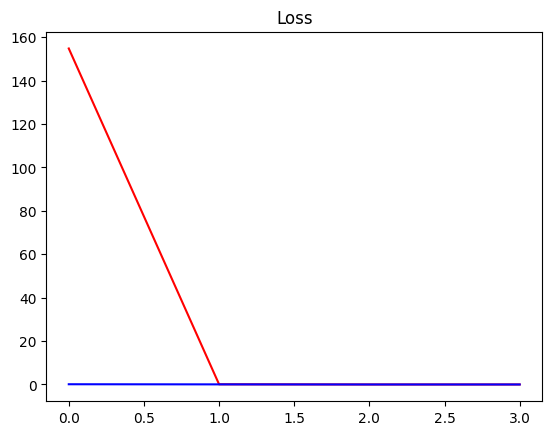

In [38]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

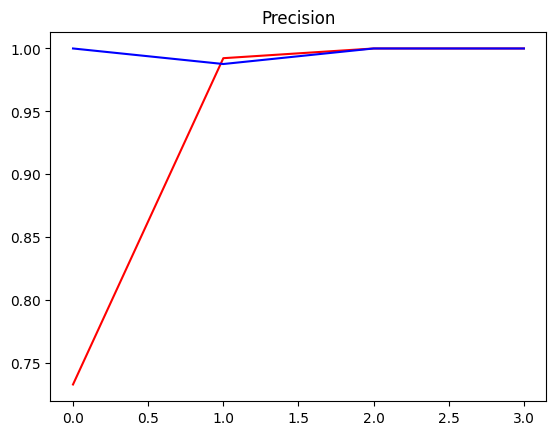

In [39]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

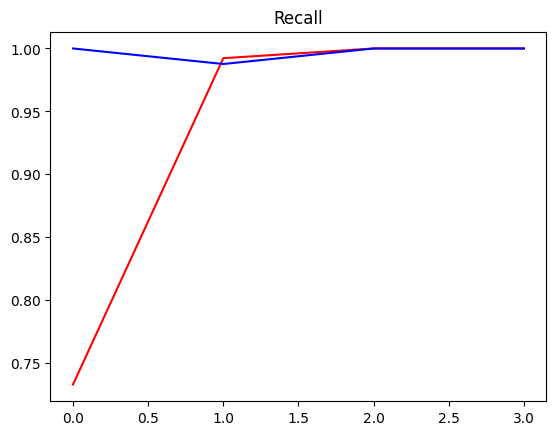

In [40]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [93]:
yhat = model.predict(x_test)

6/6 [==============================] - 0s 43ms/step


In [101]:
idx2label(yhat[21])

'Parsed_Capuchinbird_Clips'

In [102]:
idx2label(y_test[21])

'Parsed_Capuchinbird_Clips'

In [109]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

21/21 [==============================] - 1s 42ms/step - loss: 1.4096e-04 - recall: 1.0000 - precision: 1.0000
Training Accuracy:  1.0
6/6 [==============================] - 0s 34ms/step - loss: 0.0014 - recall: 1.0000 - precision: 1.0000
Testing Accuracy:  1.0


### Save Model

In [117]:
model.save("model.keras")

INFO:tensorflow:Assets written to: model.model\assets


INFO:tensorflow:Assets written to: model.model\assets
